In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Read and Plot Data
---

1. Looking at housing information inside the file `housing.csv`
2. There is a column in the DataFrame which holds median house values which can contain capped values
    - You can see them in the plot

(0, 200)

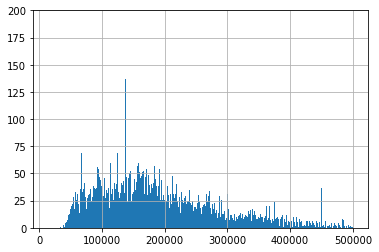

In [2]:
housing = pd.read_csv("housing.csv")
housing["median_house_value"].hist(bins=1000)
plt.ylim([0, 200])

Getting Data to Work With
---

The function `hist` above returns a plot of the data, but doesn't return the data. The next cell recreates the histogram into a data format we can use

- `hist[0]` contains the histogram $y$ values
- `hist[1]` contains the ends of the bar ranges
- `width` is the width between each entry of `hist[1]`
- `center` is the $x$ values for `hist[0]`

(0, 150)

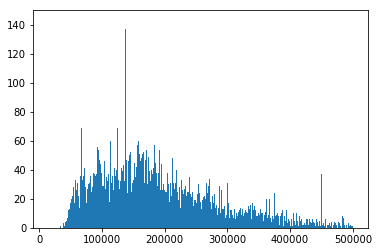

In [3]:
hist = np.histogram(housing["median_house_value"], bins=1000)
width = np.diff(hist[1])
center = (hist[1][:-1] + hist[1][1:]) / 2

plt.bar(center, hist[0], align='center', width=width)
plt.ylim([0, 150])

Useful Tools
---

1. `get_bin_range` returns the beginning and end of a bar in `hist[0]`
2. Using `get_bin_range` we can query the housing dataframe for values which fall within the range

In [4]:
def get_bin_range(center, width, elem):
    return [center[elem] - width[elem], center[elem] + width[elem]]

In [5]:
# Get the values which fit in the range
a = get_bin_range(center, width, 0)
housing.query('@a[0] <= median_house_value <= @a[1]')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2521,-122.74,39.71,16.0,255.0,73.0,85.0,38.0,1.6607,14999.0,INLAND
2799,-117.02,36.40,19.0,619.0,239.0,490.0,164.0,2.1000,14999.0,INLAND
9188,-117.86,34.24,52.0,803.0,267.0,628.0,225.0,4.1932,14999.0,INLAND
19802,-123.17,40.31,36.0,98.0,28.0,18.0,8.0,0.5360,14999.0,INLAND


Outlier Detection
---

We use modified z-score method to rank outliers. If the modified z-score is $>3.5$ it is considered an outlier

In [6]:
def outliers_modified_zscore(ys):
    threshold = 3.5
    median = np.median(ys)
    median_absolute_dev = np.median(np.abs(ys - median))
    modified_z_scores = 0.6745 * (ys - median) / median_absolute_dev
    return modified_z_scores

Details
---

The general process is:
    
1. Generate the modified zscores for the histogram $y$ values
2. Find the problem children (i.e. $\text{value}>3.5$)
3. Get the ranges for all of the problem children
4. Query the data frame for all of those ranges
5. Group the problem data frames by the `median_house_value` column and count the entries for each value
6. Print the outcome

In [7]:
zscores = outliers_modified_zscore(hist[0])
problem_children = [idx for idx, x in enumerate(zscores) if x > 3.5]
problem_childen_ranges = [get_bin_range(center, width, x) for x in problem_children]
problem_data = []
for begin, end in problem_childen_ranges:
    problem_data.append(housing.query('@begin <= median_house_value <= @end'))
for idx in range(len(problem_data)):
    print(problem_data[idx].groupby(['median_house_value']).count()['longitude'])

median_house_value
87100.0     7
87200.0     7
87300.0     4
87400.0     1
87500.0    78
87600.0     4
87700.0     5
87800.0     9
87900.0     9
Name: longitude, dtype: int64
median_house_value
112300.0      4
112400.0      1
112500.0    103
112600.0      4
112700.0      5
112800.0      6
112900.0      6
113000.0      6
113100.0      4
113200.0      6
Name: longitude, dtype: int64
median_house_value
137000.0      9
137100.0      4
137200.0     11
137300.0      7
137400.0      2
137500.0    122
137600.0      4
137700.0      2
137800.0      5
137900.0      8
Name: longitude, dtype: int64
median_house_value
149600.0     5
149700.0     4
149800.0     2
149900.0     2
150000.0    64
150100.0     3
150200.0     4
150300.0     7
150400.0    10
150500.0    10
Name: longitude, dtype: int64
median_house_value
162200.0      9
162300.0      5
162400.0      4
162500.0    117
162600.0      3
162700.0      8
162800.0      9
162900.0     10
163000.0      8
163100.0     13
Name: longitude, dtype: int64

One Problem
---

We can easily see the outlier at 450K, but we don't detect above because the count is near the median of the data. We need to split the data up to get this outlier. If the sections are too small you get a lot of outliers because modified z-scores aren't great with small amounts of data. Process:

1. Split the histogram $y$ values into sections
2. Find the modified z-scores for each section
3. Flatten the zscores
4. Run 2-6 from above

In [8]:
sections = 5
hist_into_sections = np.split(hist[0], sections)
zscores2 = np.array([outliers_modified_zscore(y) for y in hist_into_sections])
zscores2 = zscores2.flatten()
problem_children2 = [idx for idx, x in enumerate(zscores2) if x > 3.5]
problem_childen_ranges2 = [get_bin_range(center, width, x) for x in problem_children2]
problem_data2 = []
for begin, end in problem_childen_ranges2:
   problem_data2.append(housing.query('@begin <= median_house_value <= @end'))
for idx in range(len(problem_data2)):
   print(problem_data2[idx].groupby(['median_house_value']).count()['longitude'])

median_house_value
112300.0      4
112400.0      1
112500.0    103
112600.0      4
112700.0      5
112800.0      6
112900.0      6
113000.0      6
113100.0      4
113200.0      6
Name: longitude, dtype: int64
median_house_value
137000.0      9
137100.0      4
137200.0     11
137300.0      7
137400.0      2
137500.0    122
137600.0      4
137700.0      2
137800.0      5
137900.0      8
Name: longitude, dtype: int64
median_house_value
149600.0     5
149700.0     4
149800.0     2
149900.0     2
150000.0    64
150100.0     3
150200.0     4
150300.0     7
150400.0    10
150500.0    10
Name: longitude, dtype: int64
median_house_value
162200.0      9
162300.0      5
162400.0      4
162500.0    117
162600.0      3
162700.0      8
162800.0      9
162900.0     10
163000.0      8
163100.0     13
Name: longitude, dtype: int64
median_house_value
174400.0     9
174500.0    10
174600.0     4
174700.0     2
174800.0     6
174900.0     1
175000.0    63
175100.0     1
175200.0     6
Name: longitude, dty

Analysis
---

#### Original Analysis

| values | 
| ------ |
| __87500.0__ |
| 112500.0 |
| 137500.0 |
| 150000.0 |
| 162500.0 |
| 175000.0 |
| 187500.0 |
| 225000.0 |
| 350000.0 |
| 500000.0 |
| 500001.0 |

#### Sectioned Analysis

| values |
| ------ |
| 112500.0 |
| 137500.0 |
| 150000.0 |
| 162500.0 |
| 175000.0 |
| 187500.0 |
| 225000.0 |
| __275000.0__ |
| __325000.0__ |
| 350000.0 |
| __400000.0__ |
| __412500.0__ |
| __425000.0__ |
| __450000.0__ |
| 500000.0 |
| 500001.0 |

Values in bold are outliers detected by one algorithm and not the other. It is important to remove these outliers otherwise they will be learned by our models!